# Kalman Filter

### Content:
        -1D Kalman Filter (Input: motion, measurement and their variance)
        -2D Kalman Filter (Input: motion, measurement and their variance in two dimension)

### Import Inbuilt Function

In [8]:
%matplotlib notebook
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import animation
from KF_1D import Gaussian
from matplotlib.patches import Ellipse

### 1D Kalman Filter Function
    -Divided into two step, upgrade of the previous position and predict of next position
    -Output is mean of positions and their variance

In [9]:
def KF_1D (mu, sig, measurement, measurement_sig, motion, motion_sig):
        
    #update
    Kalman_Gain = sig/(sig+measurement_sig)
    posterior_mean = mu + Kalman_Gain*(measurement-mu)
    posterior_var = (1-Kalman_Gain)*sig
    
    mu = posterior_mean
    sig = posterior_var
    
    #predict
    prior_mean = mu + motion
    prior_var = sig + motion_sig
    
    return posterior_mean, posterior_var, prior_mean, prior_var

### 1D Kalman Filter Displacement

### Input:
     -measurement and its variance
     -motion and its variance
     -inital position and uncertainty
### Output:
     -belief position and variance after each measurement and motion

<IPython.core.display.Javascript object>


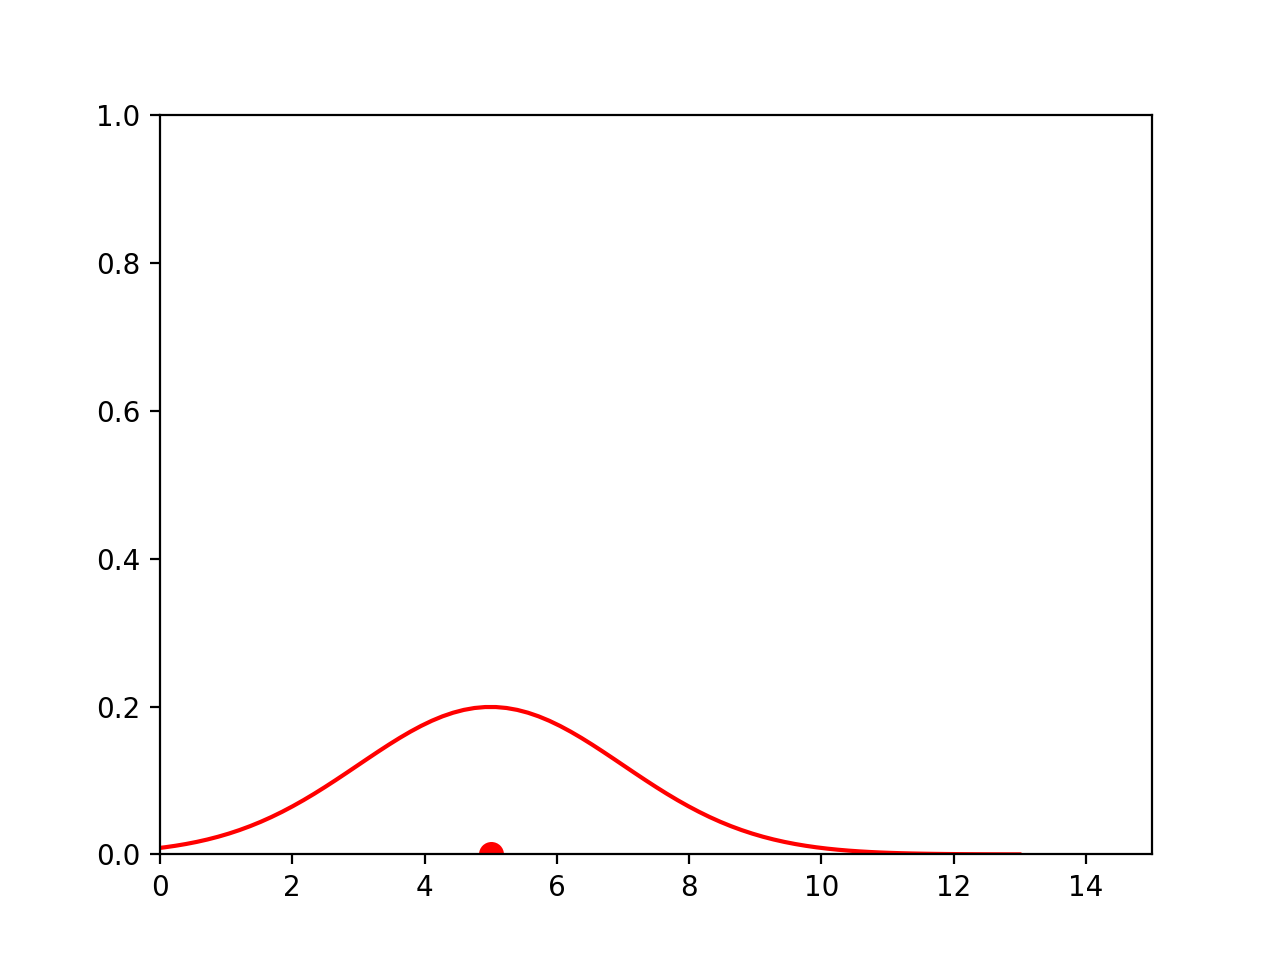

In [10]:
measurement = [5., 6., 7., 9., 10.,12] #Measurement list
motion = [1., 1., 2., 1., 1.,2] #Motion list 
measurement_sig = 4. #Measurement error
motion_sig = 2. #Motion error
mu = 0. #Initial poisition
sig = 10000. #Initial uncertainty
posterior_mean = []
posterior_var = []
prior_mean = []
prior_var = []

for i in range(len(measurement)):
    a = KF_1D (mu, sig, measurement[i], measurement_sig, motion[i], motion_sig)
    [mu,sig] = [a[2],a[3]] #Update the position
    prior_mean.append(mu)
    prior_var.append(sig)
    posterior_mean.append(a[0])
    posterior_var.append(a[1])
    
x_position = []
y_position = []
robot_pos = [] #Store the position after each step

#Calculate Gaussian Distribution
for i in range (len(prior_mean)):
    c = []
    d = []
    a = np.linspace(posterior_mean[i]-2*posterior_var[i],posterior_mean[i]+2*posterior_var[i],100)
    b = np.linspace(prior_mean[i]-2*prior_var[i],prior_mean[i]+2*prior_var[i],100)
    a.tolist()
    b.tolist()
    for j in range(len(a)):
        c.append(Gaussian (posterior_mean[i], posterior_var[i], a[j])) #Belief after measurement: Guassian Distribution
        d.append(Gaussian (prior_mean[i], prior_var[i], b[j])) #Belief after motion: Gaussian Distribution
    
    x_position.append(a)
    x_position.append(b)
    y_position.append(c)
    y_position.append(d)
    robot_pos.append(posterior_mean[i])
    robot_pos.append(prior_mean[i])

#Plot Displacement

fig = plt.figure()
ax = plt.axes(xlim=(0, 15), ylim=(0,1))
robot, = ax.plot([],[],'ro',ms = 8)
line, = ax.plot([],[],'r-',ms = 8)

def init():
    line.set_data([],[])
    robot.set_data([],[])
    return robot, line

def animate(i):
    
    if i >= len(robot_pos):
        i = 0
    
    robot.set_data(robot_pos[i],0)    
    line.set_data(x_position[i],y_position[i])
    
    return robot, line

anim = animation.FuncAnimation(fig, animate, init_func=init,   
                                frames=6000, interval=600, blit=True)    
plt.show()   

### 2D Kalman Filter Function
    Input:
        -Measurement and error
        -Motion and error

In [5]:
def KF_2D (mu, sig, measurement, measurement_sig, motion, motion_sig):
    
    #Next state Function
    F = ([[1., 0.], [0., 1.]])
    #Measurement Function
    H = ([[1., 0.], [0., 1.]])
    
    #Upgrade
    Z = ([[measurement[0], 0.],[0., measurement[1]]])
    x = mu
    P = sig
    y = Z - np.dot(H,x)
    S = np.dot(np.dot(H, P), np.transpose(H)) + measurement_sig
    K = np.dot(np.dot(P, np.transpose(H)), np.linalg.inv(S))
    ug_pos = x + np.dot(K, y)
    I = np.identity(len(np.dot(K, H)))
    ug_sig = np.dot(I-np.dot(K,H),P)
    
    #Prediction
    u = ([[motion[0], 0.],[0., motion[1]]])
    pr_pos = np.dot(F,ug_pos) + u
    pr_sig = np.dot(np.dot(F, ug_sig), np.transpose(F)) + motion_sig
    
    return ug_pos, ug_sig, pr_pos, pr_sig

### 2D Kalman Filter Displacement

### Input:
     -measurement and its variance
     -motion and its variance
     -inital position and uncertainty
### Output:
     -belief position and variance at 2D after each measurement and motion

<IPython.core.display.Javascript object>


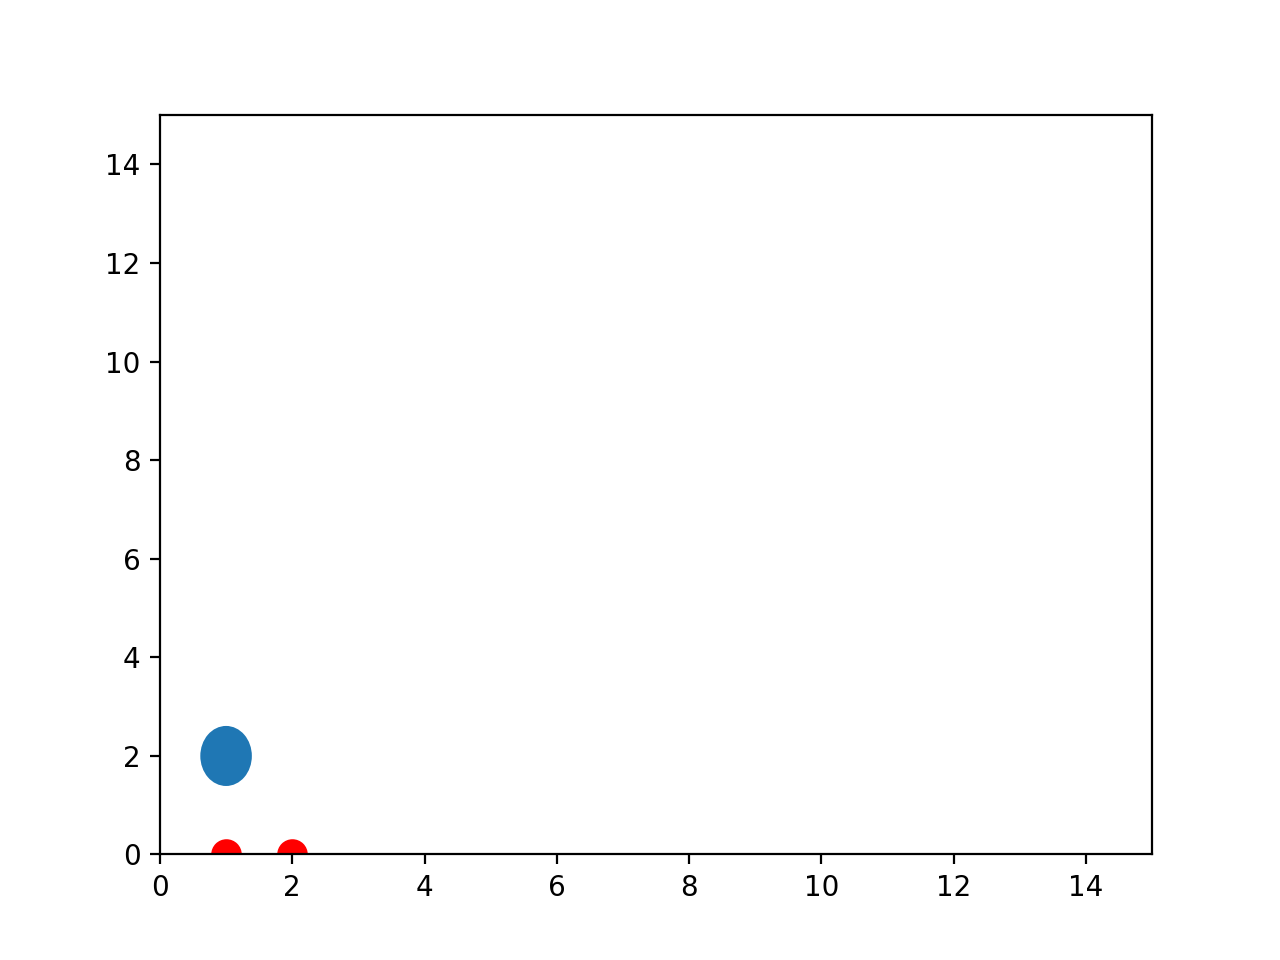

In [6]:
#Calculate the position of the robot and the variance
mu = ([[0., 0.],[0., 0.]])
sig = ([[1000., 0.],[0., 1000.]])
measurement = ([[1., 2.],[3., 4.],[5., 6.], [7,8]])
measurement_sig = ([[0.78, 0.],[0., 1.22]])
motion = ([[1., 2.],[2., 2.],[2., 2.],[2, 2]])
motion_sig = ([[2.1, 0.],[0., 1.5]])
robot_pos = []
x_sig = []
y_sig = []

for i in range(len(measurement)):
    a = KF_2D (mu, sig, measurement[i], measurement_sig, motion[i], motion_sig)
    [mu,sig] = [a[2],a[3]]
    robot_pos.append([a[0][0][0],a[0][1][1]])
    robot_pos.append([a[2][0][0],a[2][1][1]])
    x_sig.append(a[1][0][0])
    x_sig.append(a[3][0][0])
    y_sig.append(a[1][1][1])
    y_sig.append(a[3][1][1])

#Draw the ellipse
fig = plt.figure()
ax = plt.axes(xlim=(0, 15), ylim=(0,15))
robot, = ax.plot([],[],'ro',ms = 10)
e1 = Ellipse(xy=(robot_pos[0][0], robot_pos[0][1]), width=x_sig[0], height=y_sig[0], angle=0)
ax.add_patch(e1)

#Displacement of the plot
def init():
    e1.set_visible(False)
    robot.set_data([],[])
    return [e1,robot]

def animate(i):
    if i == 1:
        e1.set_visible(True)
    if i >= len(robot_pos):
        i = 0
    e1.center = (robot_pos[i][0], robot_pos[i][1])
    e1.width = x_sig[i]
    e1.height = y_sig[i]
    
    robot.set_data(robot_pos[i][0], robot_pos[i][1])
    return [e1,robot]

anim = animation.FuncAnimation(fig, animate, init_func=init,   
                                frames=6000, interval=600, blit=True)    
plt.show()
